In [13]:
# Standard library imports
import os
import json
import sys
import re
import concurrent.futures
from typing import List, Dict, Any, Tuple, TypedDict, Annotated, Optional , Literal

# Third-party imports
import boto3
import fitz
import requests
from bs4 import BeautifulSoup
from opensearchpy import OpenSearch, RequestsHttpConnection
from pydantic import BaseModel, Field, ValidationError
from IPython.display import Image

# LangChain core imports
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.tools import tool
from langchain.schema import BaseRetriever, Document

# LangGraph imports
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# LangChain AWS imports
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings

# LangChain experimental imports
from langchain_experimental.tools.python.tool import PythonAstREPLTool

# LangChain community imports
from langchain_community.tools.tavily_search import TavilySearchResults

# Operator imports
from operator import itemgetter

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage


In [14]:
def visualize(graph):
    display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    )

In [15]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # replace with your region
)
llm = ChatBedrockConverse(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    client=bedrock_client,
    temperature=0.7,
    max_tokens=2000
)

In [16]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# state생성
class SubState(TypedDict):
    messages: Annotated[list, add_messages]
    num_add: int  # Add this field to track a counter

# 노드 1 생성
def subgraph_n1(state: SubState):
    # Access the current messages and num_add
    current_messages = state["messages"]
    current_num = state["num_add"]
    print("checone-> Current messages:", current_messages)
    
    print(f"subgraph_n1: Current num_add = {current_num}")
    
    # Return updated state
    return {
        "messages": [AIMessage(content="반갑습니다")], 
        "num_add": current_num + 1
    }

# 노드 2 생성
def subgraph_n2(state: SubState):
    # Access the current messages and num_add
    current_messages = state["messages"]
    current_num = state["num_add"]
    
    print(f"subgraph_n2: Current num_add = {current_num}")
    print("checktwo-> Current messages:", current_messages)
    
    # Return updated state
    return {
        "messages": [AIMessage(content="무엇을 원하세요")], 
        "num_add": current_num + 1
    }

subgraph_builder = StateGraph(SubState)
subgraph_builder.add_node("subgraph_n1", subgraph_n1)
subgraph_builder.add_node("subgraph_n2", subgraph_n2)
subgraph_builder.add_edge(START, "subgraph_n1")
subgraph_builder.add_edge("subgraph_n1", "subgraph_n2")
subgraph_builder.add_edge("subgraph_n2", END)
subgraph = subgraph_builder.compile()




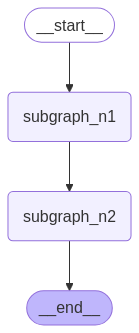

In [17]:
visualize(subgraph)

In [18]:
# Run the graph with ALL required fields in the initial state
result = subgraph.invoke({
    "messages": [HumanMessage(content="안녕하세요")],
    "num_add": 0  # Initialize num_add to 0
})

# 결과 출력
print("\nFinal state:")
print(f"num_add: {result['num_add']}")
print("Messages:")
for msg in result["messages"]:
    print(f"{msg.type}: {msg.content}")


checone-> Current messages: [HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='757ca750-de29-4f66-9493-5aeda39dcbc0')]
subgraph_n1: Current num_add = 0
subgraph_n2: Current num_add = 1
checktwo-> Current messages: [HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='757ca750-de29-4f66-9493-5aeda39dcbc0'), AIMessage(content='반갑습니다', additional_kwargs={}, response_metadata={}, id='9d155da3-5062-4ae5-9260-10cf7b31c431')]

Final state:
num_add: 2
Messages:
human: 안녕하세요
ai: 반갑습니다
ai: 무엇을 원하세요


In [19]:
class ParentState(TypedDict):
    messages_top: Annotated[list, add_messages]
    num_add: int


# 부모 그래프의 첫 번째 노드, name 키의 값을 수정하여 새로운 상태 생성
def node_1(state: ParentState):
    current_messages = state["messages_top"]
    current_num = state["num_add"]
    return {
        "messages_top": [AIMessage(content="빅뱅의 거짓말입니다")], 
        "num_add": current_num + 1
    }


# 부모 그래프 구조 정의 및 서브그래프를 포함한 노드 간 연결 관계 설정
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# 컴파일된 서브그래프를 부모 그래프의 노드로 추가
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

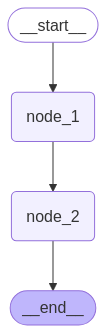

In [20]:
visualize(graph)

In [21]:
for chunk in graph.stream({"messages_higher": "좋아하는 음악은 무엇인가요?", "num_add": 0 }):
    print(chunk)


{'node_1': {'messages_top': [AIMessage(content='빅뱅의 거짓말입니다', additional_kwargs={}, response_metadata={}, id='41c33f53-916d-4745-aac4-5292207298c7')], 'num_add': 1}}
checone-> Current messages: []
subgraph_n1: Current num_add = 1
subgraph_n2: Current num_add = 2
checktwo-> Current messages: [AIMessage(content='반갑습니다', additional_kwargs={}, response_metadata={}, id='89dafd47-3c97-483e-a6b7-90e929d5e391')]
{'node_2': {'num_add': 3}}


In [22]:
result = graph.invoke({"messages_higher": "좋아하는 음악은 무엇인가요?", "num_add": 0 })

checone-> Current messages: []
subgraph_n1: Current num_add = 1
subgraph_n2: Current num_add = 2
checktwo-> Current messages: [AIMessage(content='반갑습니다', additional_kwargs={}, response_metadata={}, id='4e1001e4-359d-4120-aa71-91d2ff786bd8')]


In [23]:
result

{'messages_top': [AIMessage(content='빅뱅의 거짓말입니다', additional_kwargs={}, response_metadata={}, id='b40e4398-dfd8-418b-8440-c4727cfdd836')],
 'num_add': 3}